<a href="https://colab.research.google.com/github/xander-bennett/DS-Unit-2-Kaggle-Challenge/blob/master/module1/Xander_Bennett_DS7_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
# At this stage, we will split our training data frame one more time so that we have a validation set
# This will help us build a model that we can iterate on for our validation data, and then ultimately use on our test data
from sklearn.model_selection import train_test_split
# We'll do this using the train_test_split function from scikit learn

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
# I'm familiar with this data set, so I know that there's a longitude/latitude coordinate that isn't even in Tanzania.
# It's an outlier, so I'm going to drop it, but there are other columns that could have strange or outlandish values
# This is where i'll define a function to wrangle, train, and validate all of these test sets the same way. 
# I'll try to remove duplicate columns, maybe engineer some new features, maybe mess with date/time
# First, I'm going to do some high level overview using the profiles feature

import pandas_profiling
train.profile_report()

In [0]:
# Found some things in the profiling report that I could use:

# date_recorded only contains datetime values, but is categorical. Consider applying pd.to_datetime()
# recorded_by has constant value "GeoData Consultants Ltd"
# quantity_group is a recoding of quantity
# payment_type is a duplicate of payment

# These are all things we can manipulate to make our data set cleaner

In [0]:
import numpy as np

def wrangle(Dataframe):
  
  # Prevent SettingWithCopyWarning
  Dataframe = Dataframe.copy()

  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  Dataframe['latitude'] = Dataframe['latitude'].replace(-2e-08, 0)

  # Now that we've caused zeros, and to account for other zeros in columns that are actually missing values,
  # we can replace them with NaN
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    Dataframe[col] = Dataframe[col].replace(0,np.nan)

  # Dropping duplicate/unnecessary columns
  Dataframe = Dataframe.drop(columns = ['quantity_group', 'recorded_by', 'payment_type'])

  # changing date/time
  Dataframe.date_recorded = pd.to_datetime(Dataframe.date_recorded, infer_datetime_format=True)
  
  # Extracting

  # returning resulting dataframe
  return Dataframe


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [21]:
# Now that i've wrangled these data sets, I'm going to feed them through a scikit learn pipeline

# First, I'll separate the features into the target feature and the numeric/categorical features

# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Next, I'll feed these features and target objects into their respective matrix or vector
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
# Scikit-learn pipelines are pretty cool because combine the steps of encoding, imputing, scaling,fitting, and predicting into one step!

We can combine steps with pipelines: Encode, Impute, Scale, Fit, Predict!

The Scikit-Learn User Guide explains why pipelines are useful, and demonstrates how to use them.

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

Convenience and encapsulation. You only have to call fit and predict once on your data to fit a whole sequence of estimators.
Joint parameter selection. You can grid search over parameters of all estimators in the pipeline at once.
Safety. Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [23]:
# Without using a pipeline, I would have to go through THIS process
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.7308080808080808


In [26]:
# The same process above can be accomplished with a pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
# Importing the same classifiers, but look, this a new one for making our pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on the training data
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracty', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracty 0.7308080808080808


In [0]:
# That was much easier. We should get and plot coefficients to get a better understanding of what was influential and what wasn't.
# However, one of the drawbacks of the pipeline is that it doesn't have a .coef_ attribute. But the model INSIDE the pipeline does
# There's a way to access that information:
# The named_steps attribute shows all the inner 'steps' of the pipeline function. This will allow us to see the coefficients

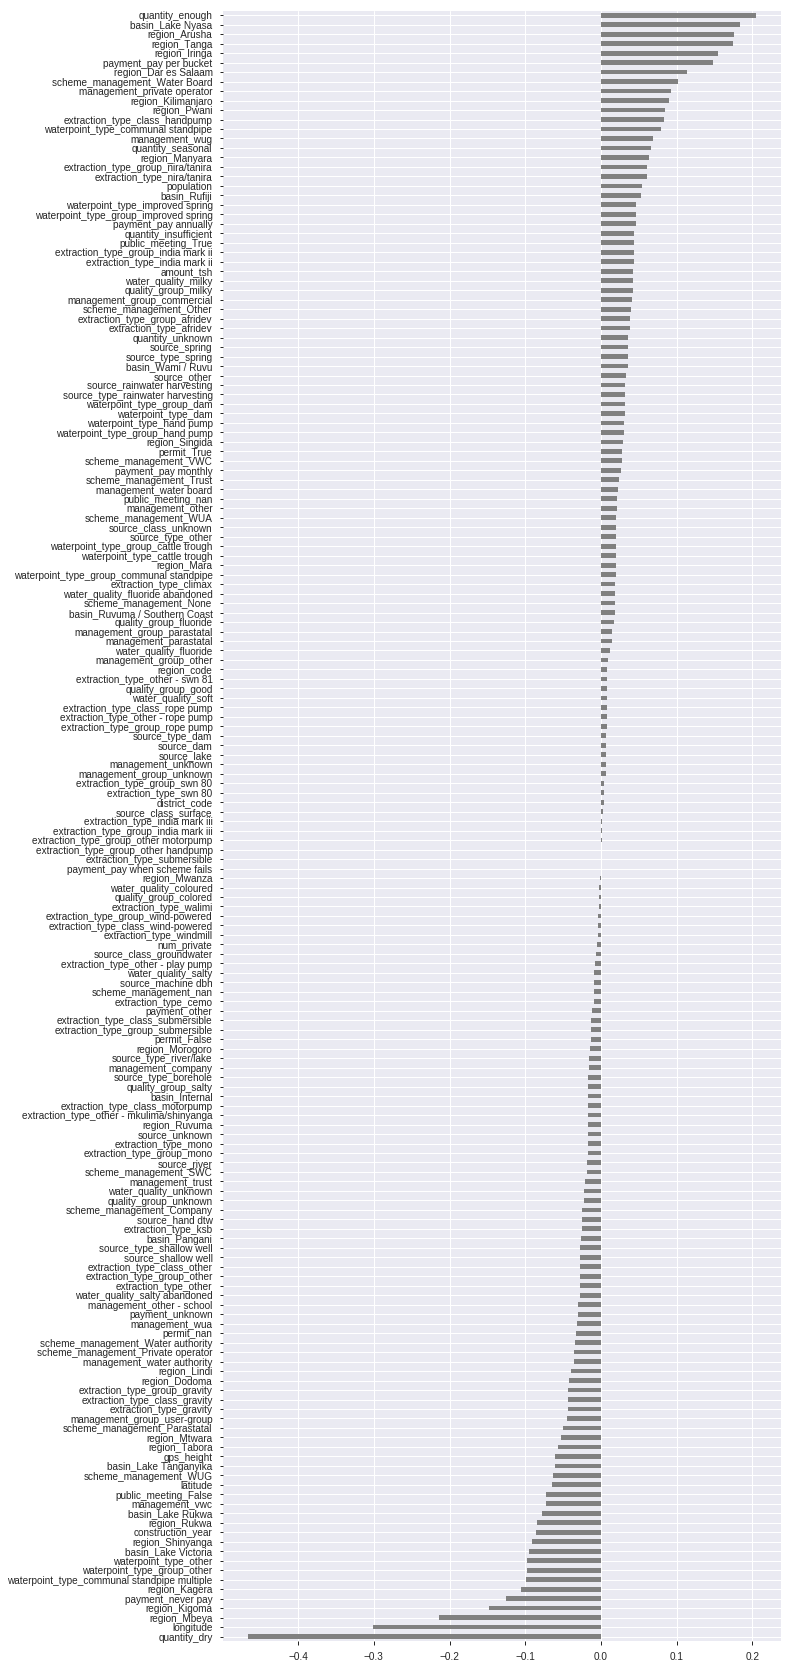

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [28]:
# Time to make a decision tree with default parameters
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42) #This is the only thing that's changed from the previous code cell
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9954755892255892
Validation Accuracy 0.7623737373737374


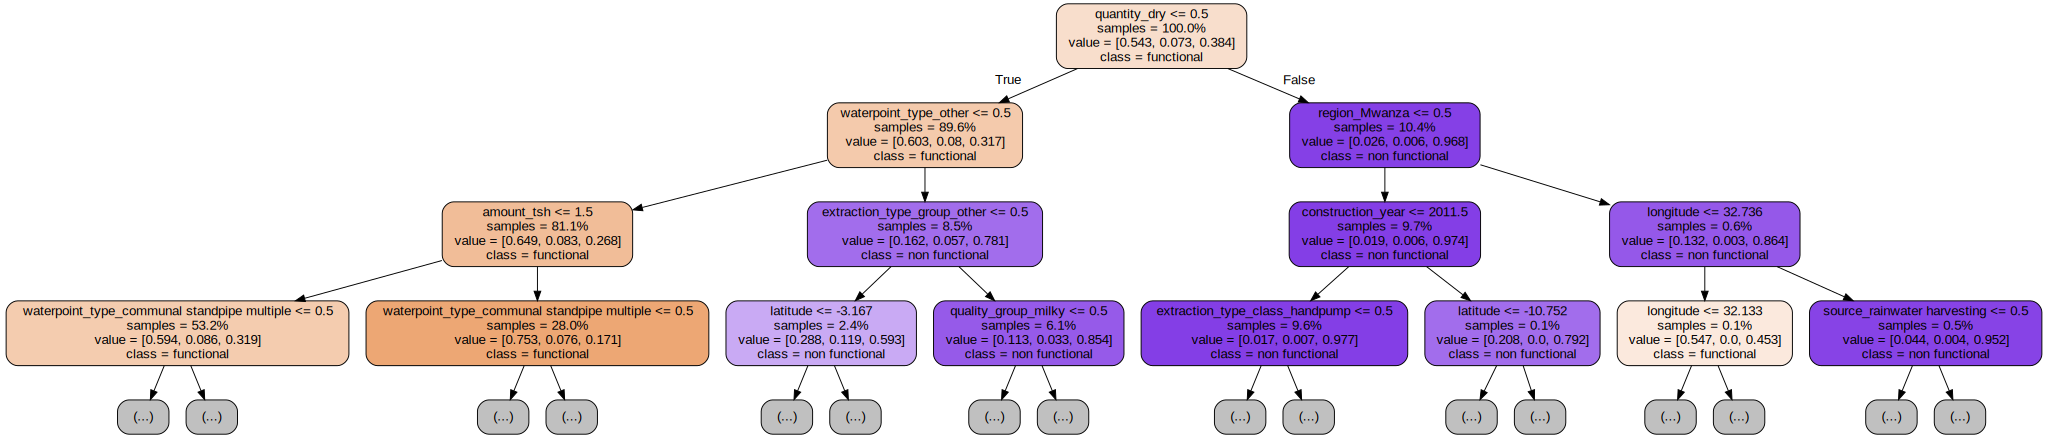

In [29]:
# This is already 3% better than my original pipeline. Time to plot the decision tree

# This doesn't happen a lot, but just to see what's under the hood:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [33]:
# We can decrease model complexity by reducing minimum node size, or the reduce the number of leaves.
# Here, i'm making the minimum amount of leaves 17
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=17, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8138047138047138
Validation Accuracy 0.7708754208754208


In [34]:
# A minor improvement. We could also manipulate the depth of the tree
# Here, we're decreasing it so that it only goes 16 layers deep

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=16, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8486111111111111
Validation Accuracy 0.7745791245791246


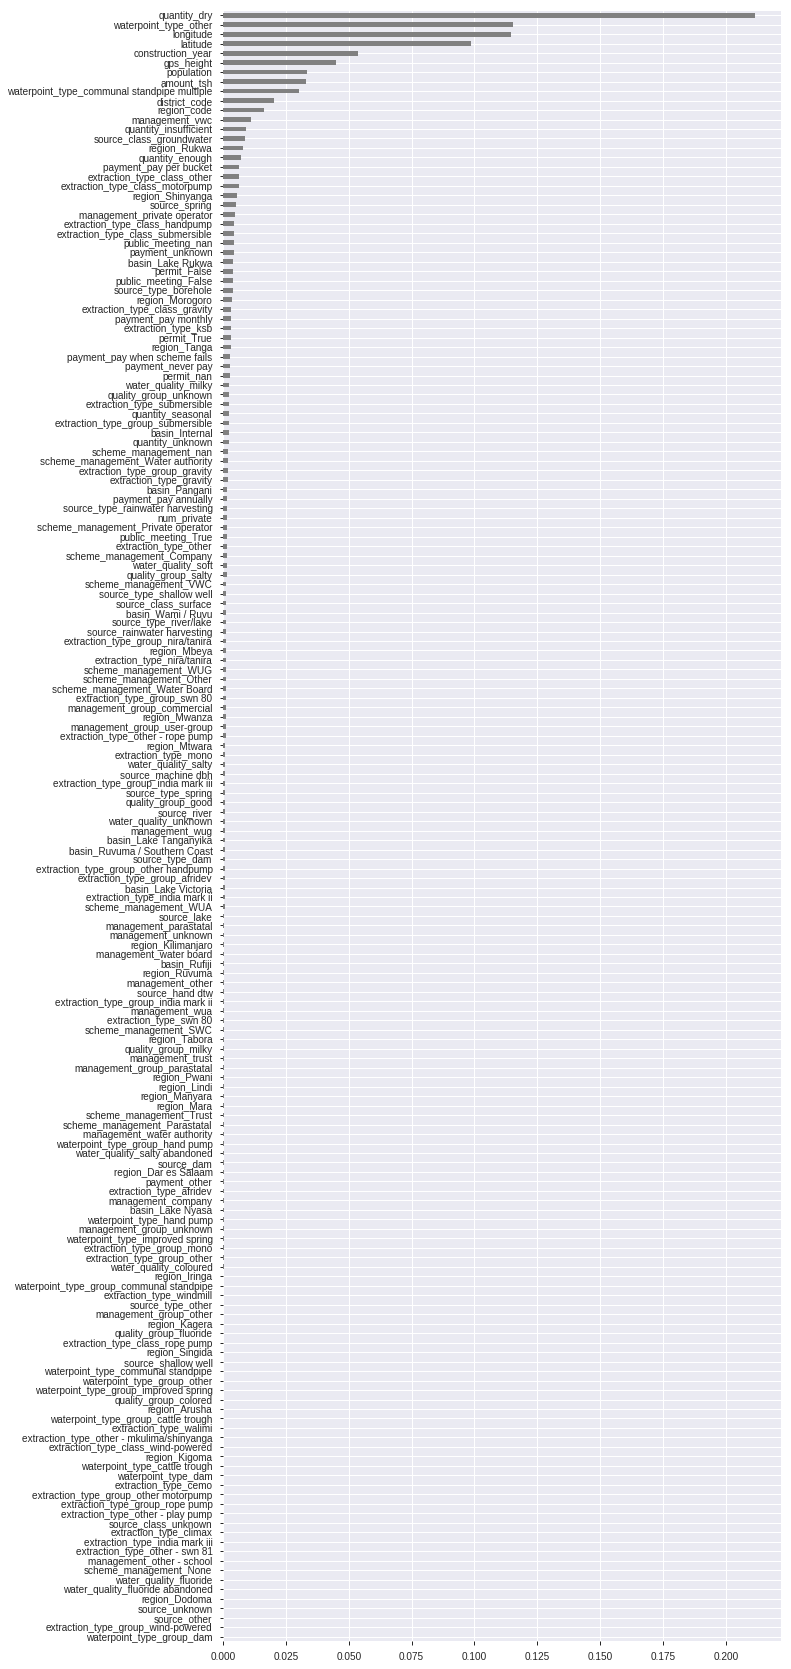

In [40]:
# an increase of .4%
# Now, lets plot feature importance. This will help us see which features were most influential in the model's determination of whether a pump was functional or not
model = pipeline.named_steps['decisiontreeclassifier']


# Linear models have coefficients, but trees have 'feature importances'.

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
# Now to upload to the kaggle competition